In [26]:
# %% [markdown]
# 교통사고 데이터 EDA 분석 노트북

# %% [code]
# 기본 설정 (폰트, 경고 제거 등)
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import os
import warnings
from matplotlib import font_manager

warnings.filterwarnings("ignore", category=UserWarning)

font_path = "C:/Windows/Fonts/malgun.ttf"
font_prop = font_manager.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False
sns.set(style="whitegrid", font=font_prop.get_name())

In [27]:
# %% [code]
# 데이터 불러오기
path = os.getcwd()
df1 = pd.read_csv(os.path.join(path, 'TAAS_사고분석.csv'), encoding='utf-8')
df2 = pd.read_csv(os.path.join(path, 'TAAS_융합분석.csv'), encoding='utf-8')

# 출처 컬럼 추가 및 병합
df1['source'] = '사고분석'
df2['source'] = '융합분석'
df = pd.concat([df1, df2], ignore_index=True)
print(f"전체 행 개수: {len(df):,}")

# %% [code]
# 위험도 통합 지표 계산
for col in ['사망자수', '중상자수', '경상자수']:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

df['incident_score'] = 1.0 + 0.7 * (df['중상자수'] > 0) + 0.3 * (df['경상자수'] > 0)
df['severity_score'] = df['사망자수'] + df['중상자수'] * 0.7 + df['경상자수'] * 0.3
df['total_risk'] = df['incident_score'] * 0.4 + df['severity_score'] * 0.6

# %% [code]
# 수치형 변수 정의
num_cols = ['사망자수', '중상자수', '경상자수', '부상신고자수',
            'incident_score', 'severity_score', 'total_risk']

전체 행 개수: 3,136,776


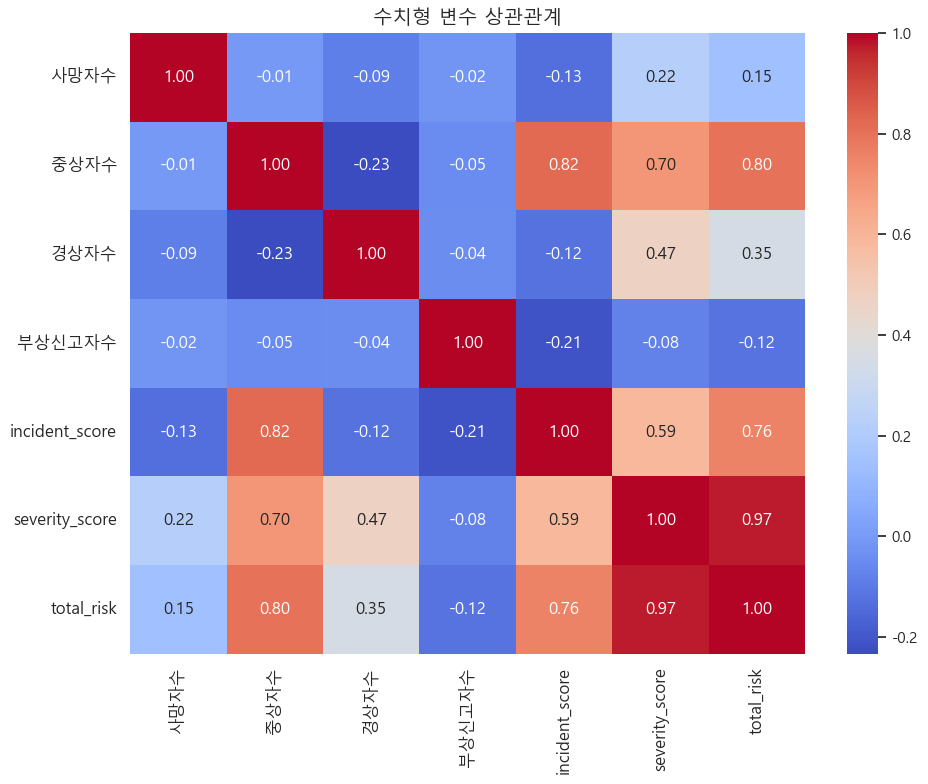

In [28]:
# %% [code]
# 수치형 변수 간 상관관계 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("수치형 변수 상관관계", fontproperties=font_prop, fontsize=14)
plt.xticks(fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)
plt.tight_layout()
plt.show()

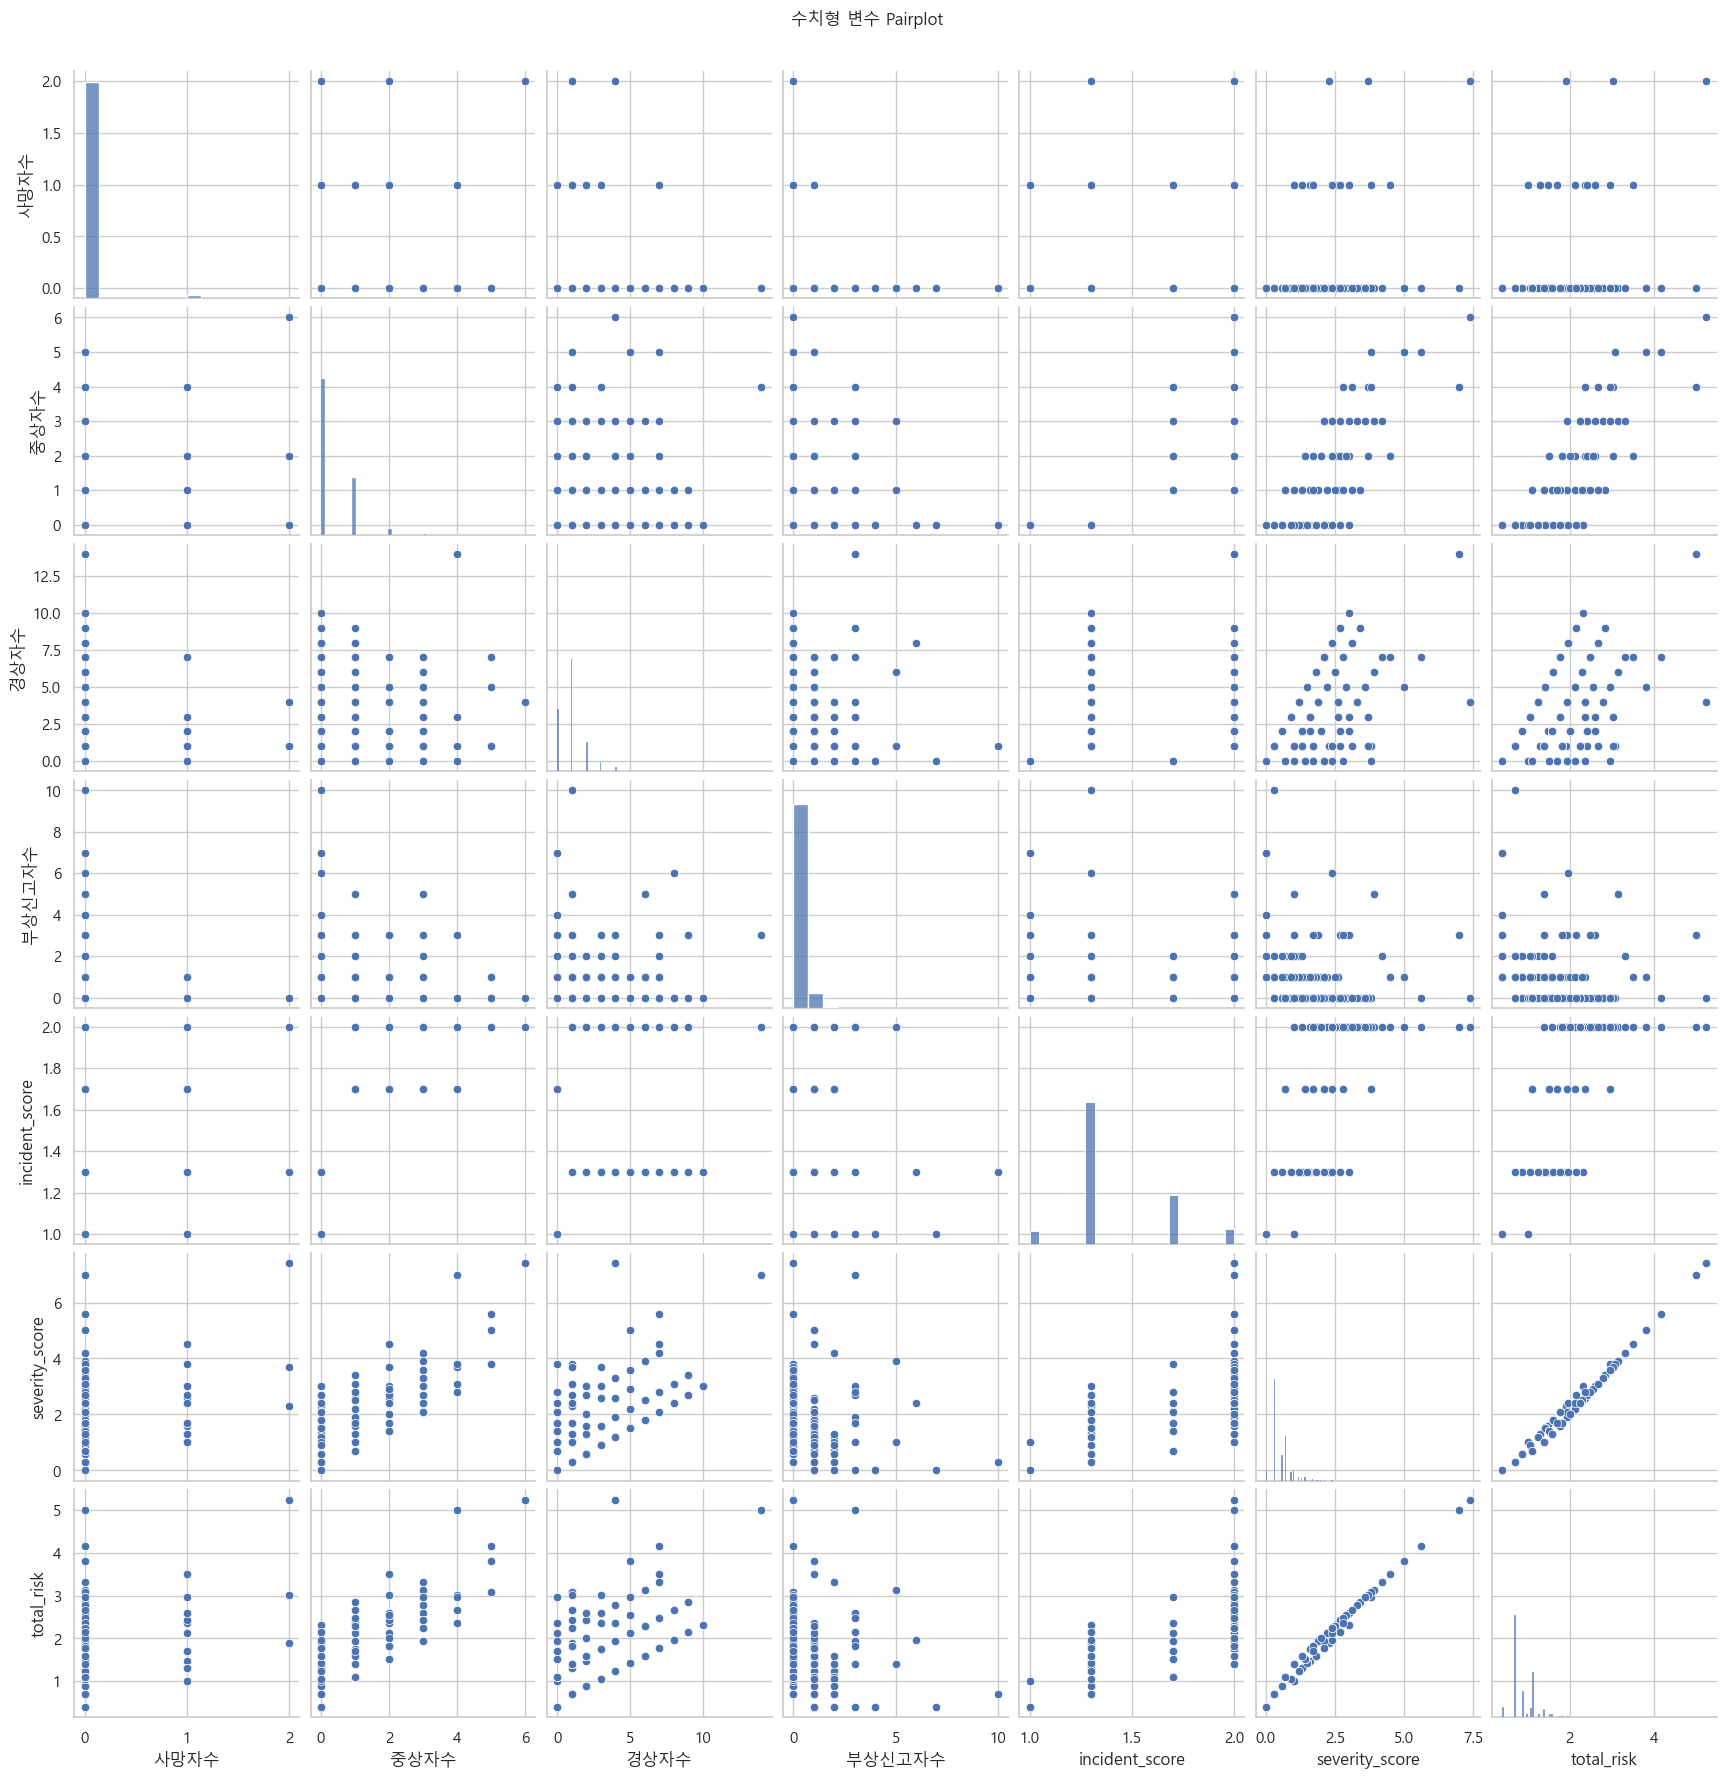

In [29]:
# %% [code]
# 수치형 변수 간 관계 시각화 (Pairplot)
# - 변수 간의 상관관계나 패턴 확인에 유용
# - 산점도, 히스토그램, 분포 밀도 등을 한눈에 비교 가능
# - 전체 데이터가 많으면 렌더링 느려지므로 최대 5,000건 샘플링

sample = df.sample(5000, random_state=42) if len(df) > 5000 else df

# pairplot 그리기
sns.pairplot(sample[num_cols])  # num_cols: 수치형 변수 리스트 (사망자수, 중상자수 등)
plt.suptitle("수치형 변수 Pairplot", y=1.02, fontproperties=font_prop)  # 전체 제목
plt.show()


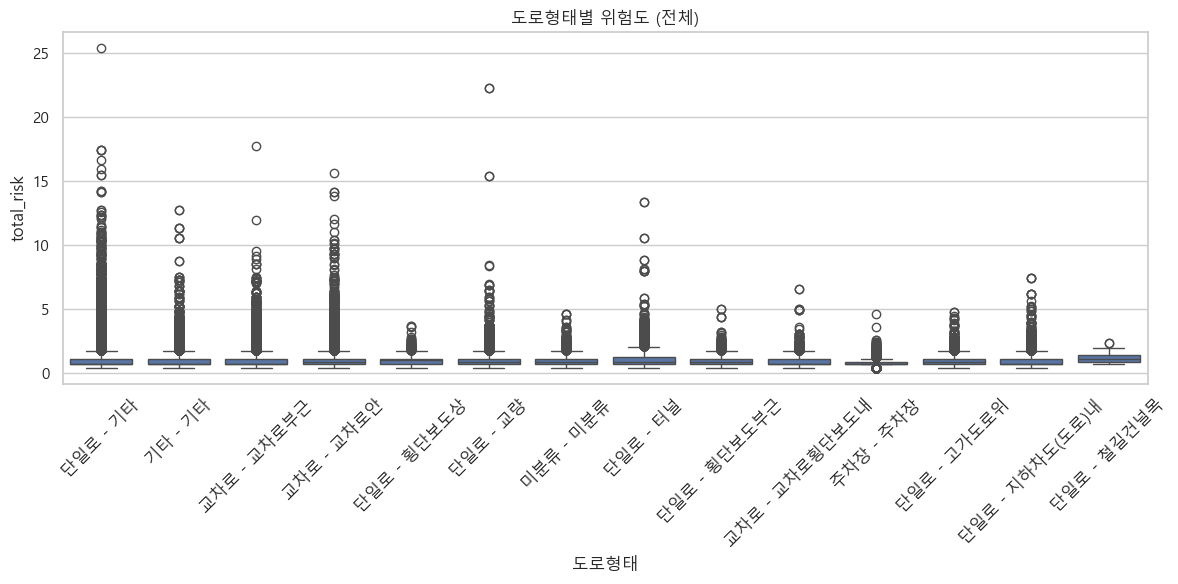

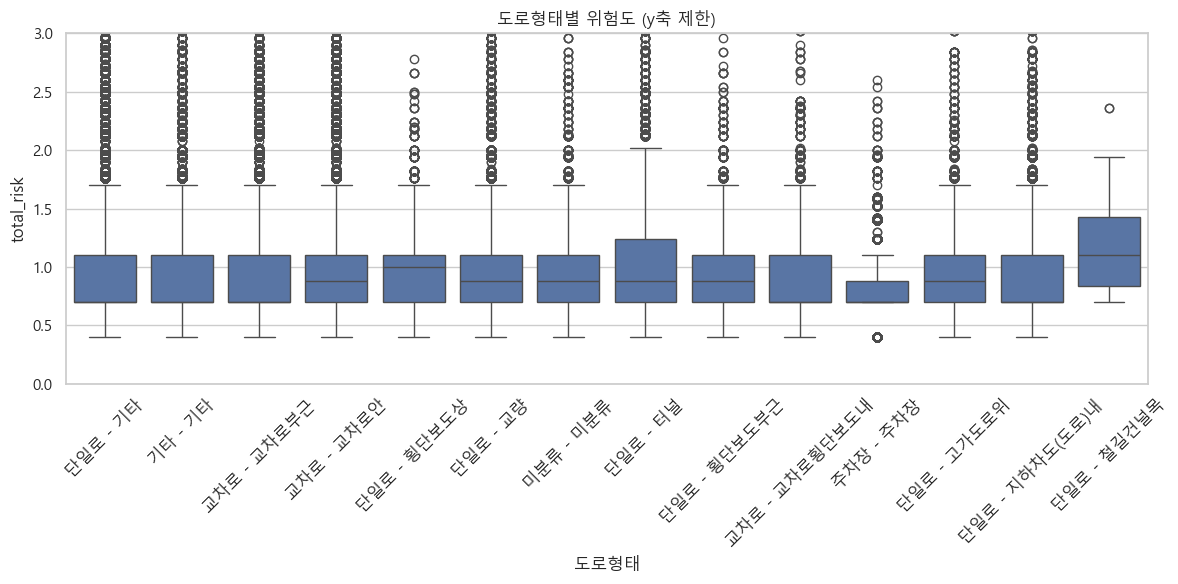

In [30]:
# %% [code]
# 도로형태별 total_risk 박스플롯 - 원본
if '도로형태' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='도로형태', y='total_risk')
    plt.title("도로형태별 위험도 (전체)", fontproperties=font_prop)
    plt.xticks(rotation=45, fontproperties=font_prop)
    plt.tight_layout()
    plt.show()

# %% [code]
# 도로형태별 total_risk 박스플롯 - y축 상한 제한 (ex: 3.0)
if '도로형태' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='도로형태', y='total_risk')
    plt.ylim(0, 3.0)  # y축 제한 설정
    plt.title("도로형태별 위험도 (y축 제한)", fontproperties=font_prop)
    plt.xticks(rotation=45, fontproperties=font_prop)
    plt.tight_layout()
    plt.show()


In [31]:
### 데이터가 있으면 아래 시각화 코드 실행

# %% [code]
# 통행량 vs 사고건수 산점도
if {'통행량', '사고건수'}.issubset(df.columns):
    df['통행량'] = pd.to_numeric(df['통행량'], errors='coerce')
    df['사고건수'] = pd.to_numeric(df['사고건수'], errors='coerce')
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='통행량', y='사고건수', hue='도로형태' if '도로형태' in df.columns else None, alpha=0.6)
    plt.title("통행량 vs 사고건수", fontproperties=font_prop)
    plt.tight_layout()
    plt.show()

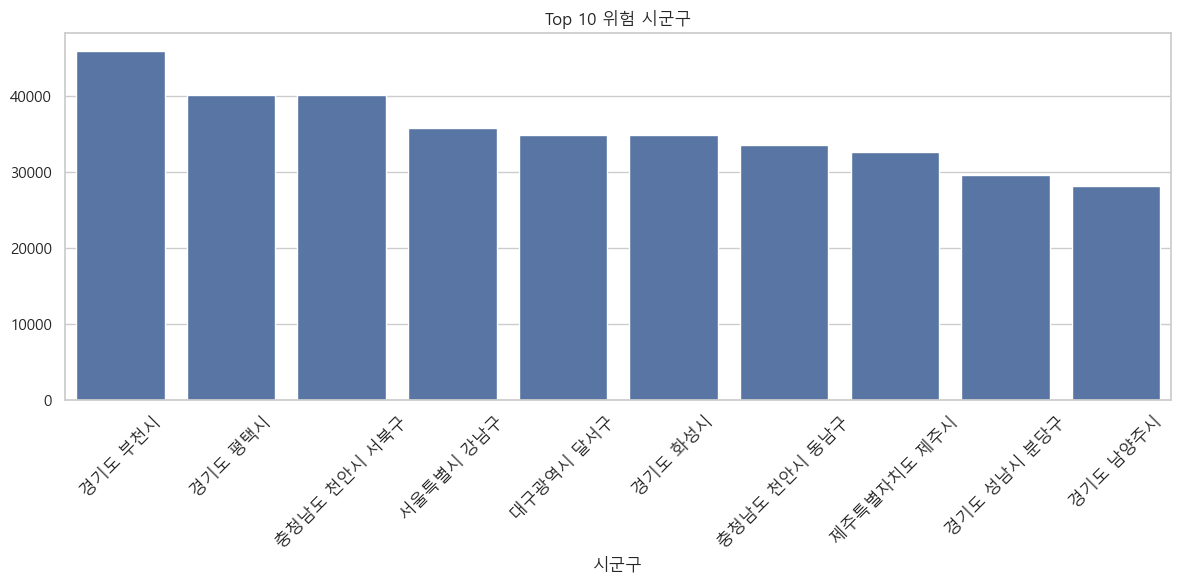

In [32]:
# %% [code]
# 시군구별 total_risk 합계 상위 10개 바플롯
if '시군구' in df.columns:
    top10 = df.groupby('시군구')['total_risk'].sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top10.index, y=top10.values)
    plt.title("Top 10 위험 시군구", fontproperties=font_prop)
    plt.xticks(rotation=45, fontproperties=font_prop)
    plt.tight_layout()
    plt.show()

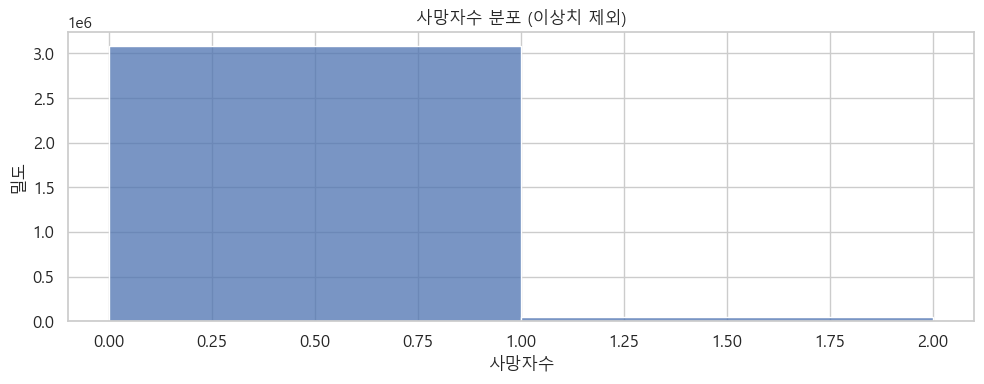

사망자수


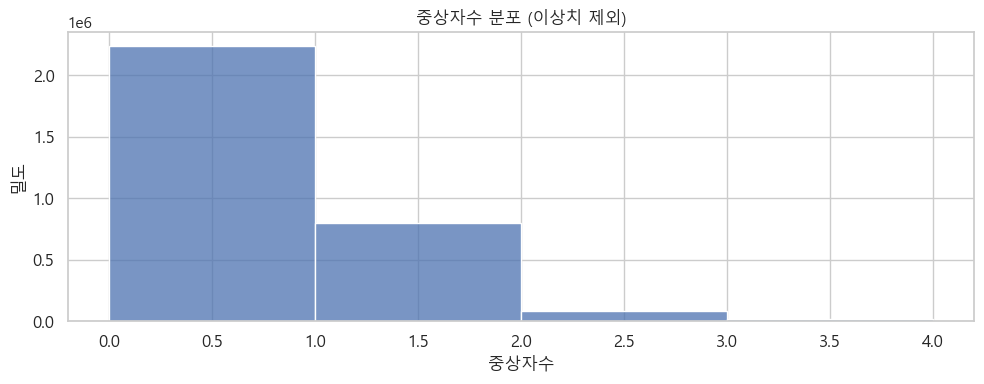

중상자수


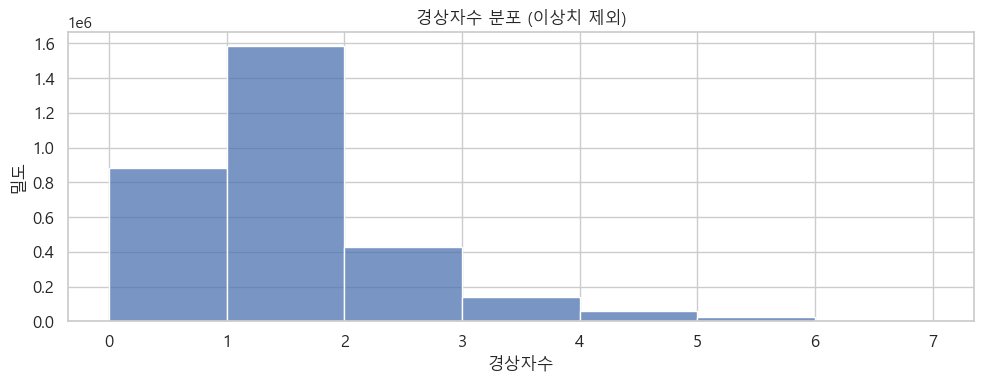

경상자수


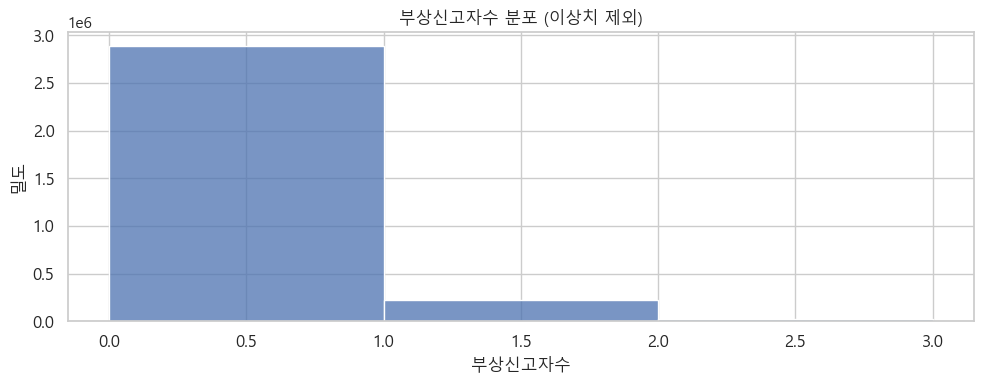

부상신고자수


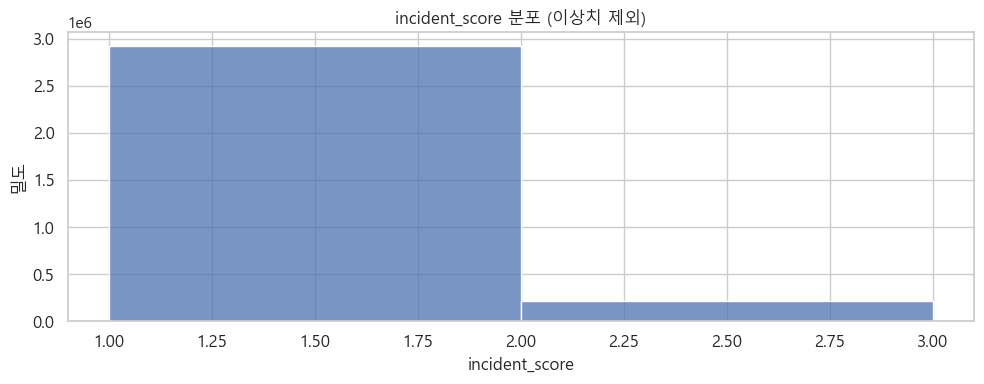

incident_score: 사고 발생 자체에 대한 단순 점수.


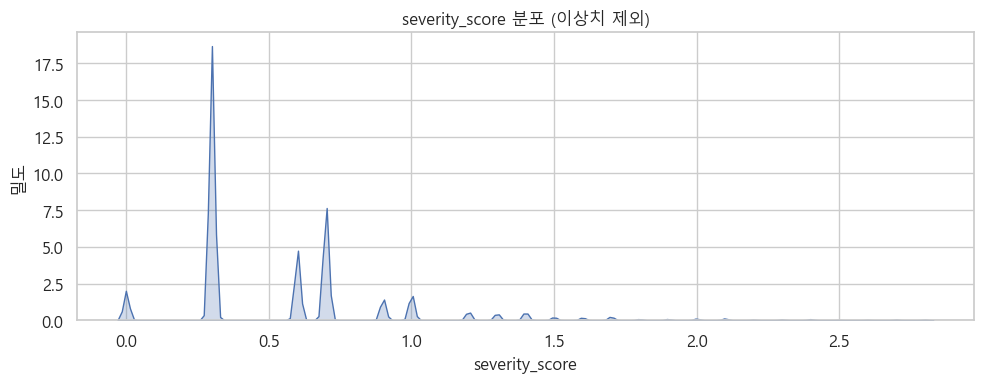

severity_score: 사망자 및 중상자 수에 기반한 심각도 지표. 치명도 높은 사고에서 높게 나타남.


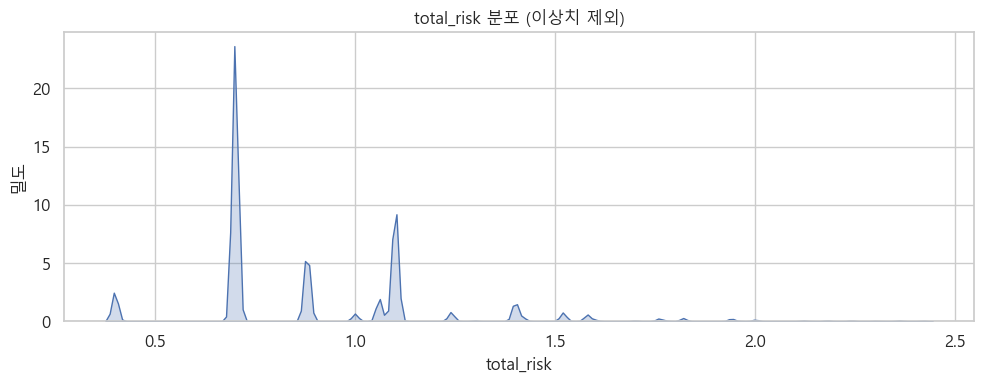

total_risk: 통합 위험도 지표. 사고의 심각성과 빈도를 함께 고려. 높은 값은 중대사고 가능성.


In [33]:
# %% [code]
# 수치형 변수의 분포 시각화 (KDE 또는 Histogram)
# - 이상치 제거 후 분포 확인
# - 변수 특성에 따라 histplot 또는 kdeplot 자동 선택
# - 해석 주석 출력 포함

for col in num_cols:
    try:
        # 수치형 변환 및 결측 제거
        series = pd.to_numeric(df[col], errors='coerce').dropna()
        if len(series) == 0:
            continue

        # 이상치 제거 (하위 0.1%, 상위 99.5%)
        q_low, q_high = series.quantile([0.001, 0.995])
        series = series[(series >= q_low) & (series <= q_high)]

        # 시각화 시작
        plt.figure(figsize=(10, 4))

        # 이산형 변수 또는 고유값 적은 경우: histplot
        if series.nunique() < 10 or col in ['incident_score', '사망자수', '중상자수']:
            sns.histplot(series, bins=range(int(series.min()), int(series.max()) + 2), kde=False)
        else:
            sns.kdeplot(series, fill=True, bw_adjust=0.5)

        plt.title(f"{col} 분포 (이상치 제외)", fontproperties=font_prop)
        plt.xlabel(col, fontproperties=font_prop)
        plt.ylabel("밀도", fontproperties=font_prop)
        plt.xticks(fontproperties=font_prop)
        plt.yticks(fontproperties=font_prop)
        plt.tight_layout()
        plt.show()

        # 변수별 해석 출력
        if col == "total_risk":
            print("total_risk: 통합 위험도 지표. 사고의 심각성과 빈도를 함께 고려. 높은 값은 중대사고 가능성.")
        elif col == "severity_score":
            print("severity_score: 사망자 및 중상자 수에 기반한 심각도 지표. 치명도 높은 사고에서 높게 나타남.")
        elif col == "incident_score":
            print("incident_score: 사고 발생 자체에 대한 단순 점수.")
        elif col == "부상신고자수":
            print("부상신고자수")
        elif col == "경상자수":
            print("경상자수")
        elif col == "중상자수":
            print("중상자수")
        elif col == "사망자수":
            print("사망자수")

    except Exception as e:
        print(f"{col} skipped: {e}")


In [34]:
# %% [code]
# statsmodels: 다중 회귀분석을 통한 변수 해석
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 필수 컬럼이 있는 경우에만 실행
required_cols = {'사망자수', '중상자수', '경상자수', 'total_risk'}
if required_cols.issubset(df.columns):
    # 결측치 제거
    df_stats = df[list(required_cols)].dropna()

    # 회귀 모델 적합 (종속변수: total_risk)
    model = smf.ols("total_risk ~ 사망자수 + 중상자수 + 경상자수", data=df_stats).fit()

    # 요약 출력
    print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             total_risk   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 4.442e+07
Date:                Wed, 06 Aug 2025   Prob (F-statistic):               0.00
Time:                        15:14:11   Log-Likelihood:             4.6981e+06
No. Observations:             3136776   AIC:                        -9.396e+06
Df Residuals:                 3136772   BIC:                        -9.396e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5167   4.94e-05   1.04e+04      0.0

In [ ]:
# # %% [code]
# cat_cols = ['도로형태', '사고유형', '법규위반', '기상상태', '시군구']  # 존재하는 컬럼만 필터링
# for col in cat_cols:
#     if col in df.columns:
#         plt.figure(figsize=(12, 6))
#         sns.boxplot(data=df, x=col, y='total_risk')
#         plt.title(f"{col}별 total_risk 비교", fontproperties=font_prop)
#         plt.xticks(rotation=45, fontproperties=font_prop)
#         plt.tight_layout()
#         plt.show()


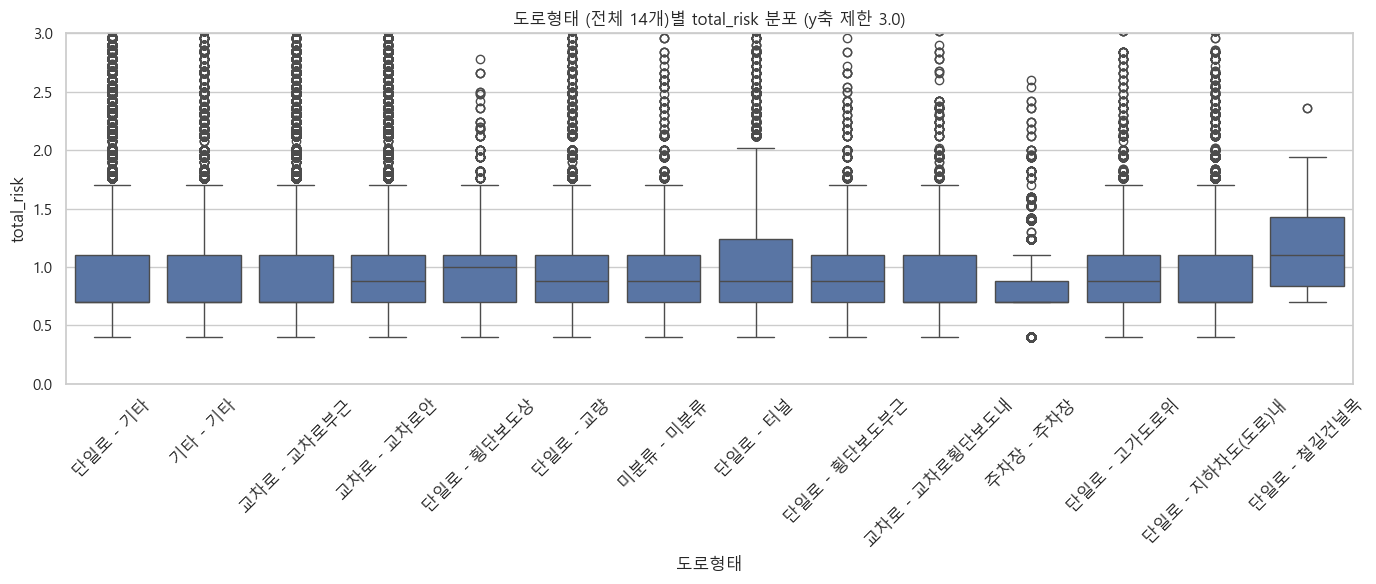

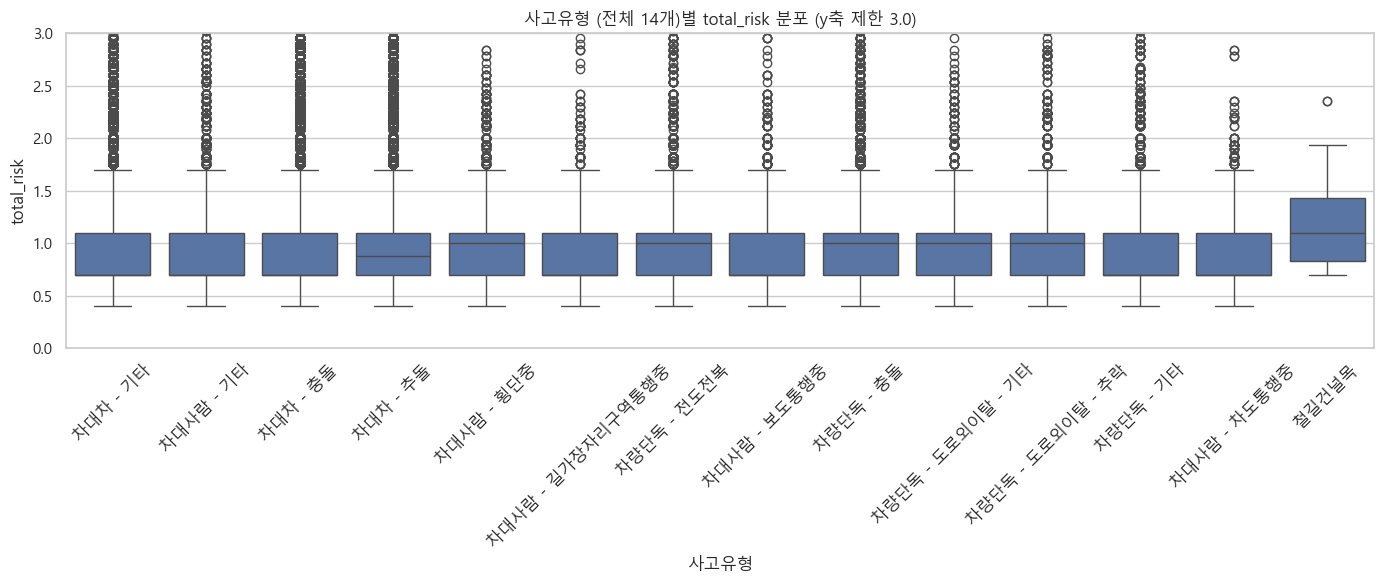

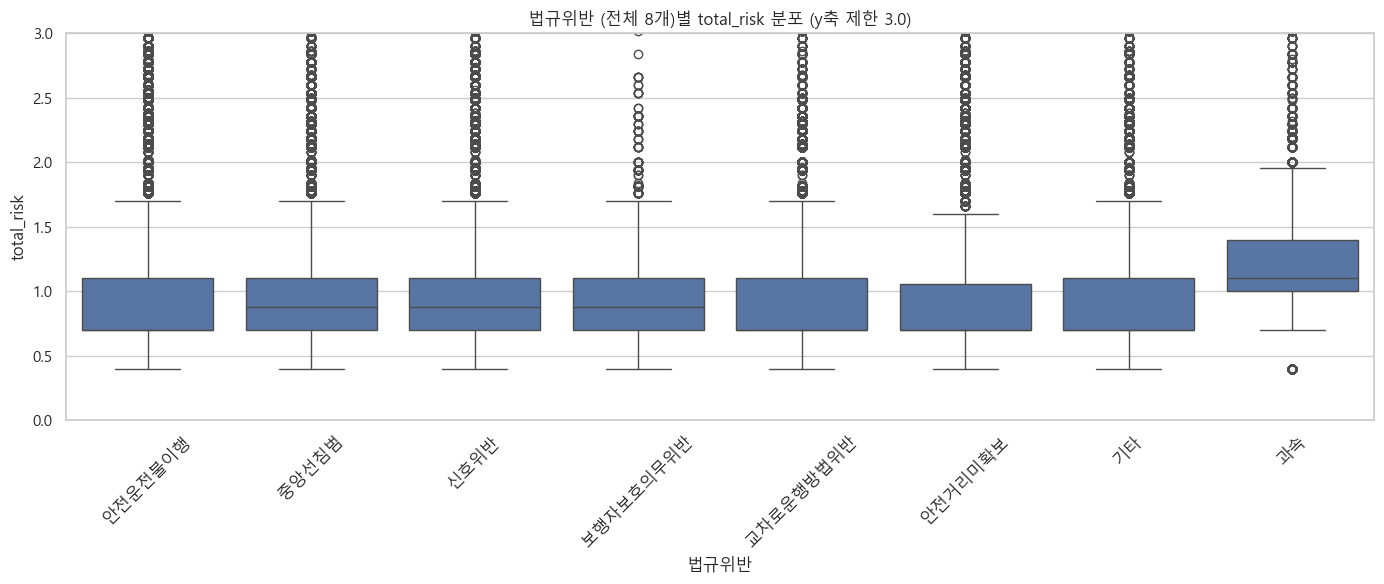

In [36]:
# %% [code]
# 분석할 범주형 변수 리스트
cat_cols = ['도로형태', '사고유형', '법규위반']

# 박스플롯 그리는 함수 정의
def plot_box_by_category(col, max_y=3.0):
    # 범주 수 체크
    if col in df.columns:
        unique_vals = df[col].dropna().unique()
        n_cat = len(unique_vals)

        # 상위 25개만 남기기 or 전부
        if n_cat > 25:
            top_25 = df[col].value_counts().head(25).index
            df_plot = df[df[col].isin(top_25)].copy()
            title = f"{col} (빈도 상위 25개)"
        else:
            df_plot = df.copy()
            title = f"{col} (전체 {n_cat}개)"

        # 박스플롯 그리기
        plt.figure(figsize=(14, 6))
        sns.boxplot(data=df_plot, x=col, y='total_risk')
        plt.ylim(0, max_y)
        plt.title(f"{title}별 total_risk 분포 (y축 제한 {max_y})", fontproperties=font_prop)
        plt.xticks(rotation=45, fontproperties=font_prop)
        plt.tight_layout()
        plt.show()

# %% [code]
# 모든 범주형 변수에 대해 박스플롯 그리기
for col in cat_cols:
    plot_box_by_category(col, max_y=3.0)


In [ ]:
# %% [code]
if '사고유형' in df.columns:
    sample = df.sample(3000, random_state=0) if len(df) > 3000 else df
    sns.pairplot(sample[num_cols + ['사고유형']], hue='사고유형')
    plt.suptitle("사고유형에 따른 수치형 변수 관계", y=1.02, fontproperties=font_prop)
    plt.show()


In [ ]:
# %% [code]
if '도로형태' in df.columns:
    roadtype_group = df.groupby('도로형태')[num_cols].mean().round(2)
    display(roadtype_group)


In [ ]:
# %% [code]
correlation_table = df[num_cols].corr().round(2)
display(correlation_table)


In [ ]:
# %% [code]
if '도로명' in df.columns:
    top_road = df.groupby('도로명')['total_risk'].sum().sort_values(ascending=False).head(10)
    print("Top 10 위험 도로:")
    print(top_road)

if '시군구' in df.columns:
    top_region = df.groupby('시군구')['total_risk'].sum().sort_values(ascending=False).head(10)
    print("Top 10 위험 시군구:")
    print(top_region)


In [ ]:
# %% [code]
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [ ]:
# total_risk 상위 1% 사고들
top1 = df[df['total_risk'] >= df['total_risk'].quantile(0.99)]

# 이 중에서 도로형태, 사고유형 등 범주형 변수 분포 확인
for col in ['도로형태', '사고유형', '법규위반']:
    if col in df.columns:
        print(f"[{col}] 분포 (total_risk 상위 1%)")
        print(top1[col].value_counts(normalize=True).round(2))
        print()


In [ ]:
## 통행량 데이터가 있으면 실행

if {'통행량', '사고건수', '도로명'}.issubset(df.columns):
    df['사고율'] = df['사고건수'] / df['통행량']
    good = df[(df['통행량'] > df['통행량'].quantile(0.8)) & (df['사고율'] < df['사고율'].quantile(0.2))]
    print("안전 우수 도로 Top 10:")
    print(good.groupby('도로명')['사고율'].mean().sort_values().head(10))


In [ ]:
# 예시: '발생일시'가 있는 경우 시간 추출
if '발생일시' in df.columns:
    df['사고시간'] = pd.to_datetime(df['발생일시'], errors='coerce').dt.hour
    plt.figure(figsize=(10, 5))
    sns.histplot(df['사고시간'], bins=24, kde=False)
    plt.title("시간대별 사고 발생 분포", fontproperties=font_prop)
    plt.xlabel("시각", fontproperties=font_prop)
    plt.tight_layout()
    plt.show()


In [ ]:
# SHAP 값 기준으로 주요 기여 변수 식별
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
shap_df['dominant'] = shap_df.abs().idxmax(axis=1)
print("사고별 SHAP 기여도가 가장 큰 변수 분포:")
print(shap_df['dominant'].value_counts())


In [ ]:
# pivot_table로 교차 시각화
if {'사고유형', '도로형태'}.issubset(df.columns):
    pivot = df.pivot_table(index='사고유형', columns='도로형태', values='total_risk', aggfunc='mean')
    plt.figure(figsize=(14, 8))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title("사고유형 vs 도로형태 평균 위험도", fontproperties=font_prop)
    plt.tight_layout()
    plt.show()


In [ ]:
# %% [code]
# SHAP: 머신러닝 모델 기반 변수 중요도 해석
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split

# 컬럼 존재 시 실행
feature_cols = ['사망자수', '중상자수', '경상자수']
target_col = 'total_risk'

if set(feature_cols + [target_col]).issubset(df.columns):
    df_shap = df[feature_cols + [target_col]].dropna()

    # 데이터 분리
    X = df_shap[feature_cols]
    y = df_shap[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 모델 학습
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)

    # SHAP 값 계산
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)

    # 요약 그래프 출력
    shap.summary_plot(shap_values, X_test)


In [ ]:
# %% [code]
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split

# 피쳐 및 타겟 지정
feature_cols = ['사망자수', '중상자수', '경상자수']
target_col = 'total_risk'

# 결측치 제거
df_shap = df[feature_cols + [target_col]].dropna()
X = df_shap[feature_cols]
y = df_shap[target_col]

# 학습 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# SHAP 값 계산
explainer = shap.Explainer(model)
shap_values = explainer(X_test)


In [ ]:
# %% [code]
# SHAP dependence plot - 하나의 변수에 대해 해석
shap.dependence_plot("중상자수", shap_values.values, X_test, interaction_index="경상자수")


In [ ]:
# %% [code]
# Force plot용 JS 시각화 초기화
shap.initjs()

# 테스트셋 중 첫 번째 샘플에 대한 Force Plot
shap.force_plot(explainer.expected_value, shap_values.values[0], X_test.iloc[0])


In [ ]:
# %% [code]
# Force plot 여러 개 저장 (5개 샘플)
for i in range(5):
    shap.save_html(f"force_plot_{i}.html", shap.force_plot(
        explainer.expected_value, shap_values.values[i], X_test.iloc[i]))


In [ ]:
# %% [code]
# interaction values 계산을 위한 TreeExplainer 사용
tree_explainer = shap.TreeExplainer(model)

# 상호작용값 계산 (시간 좀 걸림)
interaction_values = tree_explainer.shap_interaction_values(X_test)


In [ ]:
# %% [code]
# Summary plot with interaction values
shap.summary_plot(interaction_values, X_test)


In [ ]:
# %% [code]
# 특정 변수 기준 상호작용 해석
shap.dependence_plot(
    "중상자수", 
    interaction_values, 
    X_test, 
    interaction_index="경상자수"  # 상호작용 보는 변수
)
